<img src="Imagens/Rio1.png"/>

# Transferência de estilo

Antes de realizar um processo de transferência de estilo, vamos deixar claro que de fato isto é.

Transferência de estilo é um **processo de modificar o estilo de uma imagem e, ao mesmo tempo, preservar o seu conteúdo**. O artigo que define todo este processo pode ser visto em https://arxiv.org/pdf/1508.06576.pdf.

Um exemplo simples, pode ser visto na figura abaixo. (ref: https://www.techleer.com/articles/466-insight-into-fast-style-transfer-in-tensorflow/)

Equações: https://arxiv.org/pdf/1508.06576.pdf

<img src="Imagens/ex1.jpg"/>

Desta forma, a ideia é simples. Há uma imagem de entrada e uma imagem de estilo. A saída será a sua imagem de entrada estilizada. Ou seja:

- Entrada + Estilo -> Entrada estilizada

Vamos programar uma rede neural, passo a passo, para fazer a transferência de estilo. Vamos começar importando algumas bibliotecas.

#### Imporantando bibliotecas

In [1]:
import numpy as np
from PIL import Image
import requests
from io import BytesIO

from keras import backend as K
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b

Using TensorFlow backend.


#### Definindo alguns parâmetros

In [2]:
media_rgb_imagenet = [123.68, 116.779, 103.939] # Média dos valores RGB das imagens do ImageNet
peso_conteudo = 0.02
peso_estilo = 4.5
variacao_peso = 0.995
variacao_fator_custo = 1.25
largura_imagem = 260
altura_imagem = 260
canais = 3 # R G B

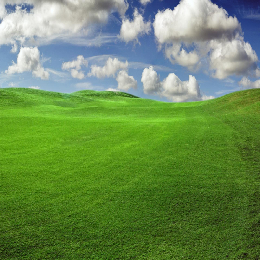

In [3]:
# Lendo imagem de entrada e colocando no tamanho padrão escolhido (500x500)
img_entrada = Image.open('Imagens/win_xp.jpg')
img_entrada = img_entrada.resize((altura_imagem,largura_imagem))
img_entrada.save('entrada.png')
img_entrada

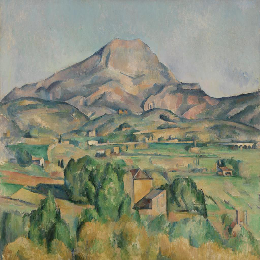

In [4]:
# Lendo imagem de estilo e colocando no tamanho padrão escolhido (500x500)
img_estilo = Image.open('Imagens/barnes.jpg')
img_estilo = img_estilo.resize((altura_imagem,largura_imagem))
img_estilo.save('estilo.png')
img_estilo

#### Normalização pela média e transformação de RGB para BGR

In [5]:
img_entrada_arr = np.asarray(img_entrada, dtype="float32") # shape = (largura_imagem, altura_imagem, canais)
img_entrada_arr = np.expand_dims(img_entrada_arr, axis=0) # shape = (1, largura_imagem, altura_imagem, canais)
img_entrada_arr[:, :, :, 0] -= media_rgb_imagenet[2]
img_entrada_arr[:, :, :, 1] -= media_rgb_imagenet[1]
img_entrada_arr[:, :, :, 2] -= media_rgb_imagenet[0]
img_entrada_arr = img_entrada_arr[:, :, :, ::-1] # Troca RGB por BGR

img_estilo_arr = np.asarray(img_estilo, dtype="float32") # shape = (largura_imagem, altura_imagem, canais)
img_estilo_arr = np.expand_dims(img_estilo_arr, axis=0) # shape = (1, largura_imagem, altura_imagem, canais)
img_estilo_arr[:, :, :, 0] -= media_rgb_imagenet[2]
img_estilo_arr[:, :, :, 1] -= media_rgb_imagenet[1]
img_estilo_arr[:, :, :, 2] -= media_rgb_imagenet[0]
img_estilo_arr = img_estilo_arr[:, :, :, ::-1] # Troca RGB por BGR

## Modelo da Rede Neural

Vamos usar um modelo pré-treinado de Rede Neural Convolucional (CNN), a VGG-16. Este modelo é a escolha certa para o processamento de imagens. Além disso, nos permite extrair separadamente o conteúdo e o estilo de uma imagem, e é exatamente isso que queremos. Então, passaremos as duas imagens pelo VGG e inicializaremos a imagem a ser gerada em uma imagem aleatória.

<img src="Imagens/vgg16.png"/>

Tenha em mente que não usaremos camadas totalmente conectadas (azul) e softmax (amarelo). Eles agem como um classificador que não precisamos aqui. Vamos usar apenas extratores de características, ou seja, camadas convolucionais (preto) e de MaxPooling (vermelho). Neste modelo, as informações são importantes e, usando o MaxPooling na CNN, estamos jogando fora um grande número de valores de pixels da camada anterior e estamos mantendo apenas os valores mais altos.

In [6]:
entrada = K.variable(img_entrada_arr)
estilo = K.variable(img_estilo_arr)
imagem_combinada = K.placeholder((1, largura_imagem, altura_imagem, canais))

tensor_entrada = K.concatenate([entrada, estilo, imagem_combinada], axis=0)
model = VGG16(input_tensor=tensor_entrada, include_top=False, weights='imagenet')

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

## O problema a ser resolvido

O problema a ser resolvido para a transferência de estilo é um problema de otimização. Para tal, devemos minimizar três funções:
 - Custo do conteúdo (distância entre as imagens de entrada e saída);
 - Custo de estilo (distância entre o estilo e a imagens de saída);
 - Custo de variação total (regularização - suavidade espacial para minimizar a imagem de saída).


### Custo do conteúdo

<img src="Imagens/content_loss.png"/>

In [8]:
def custo_conteudo(conteudo, combinacao):
    return K.sum(K.square(combinacao - conteudo))

layers = dict([(layer.name, layer.output) for layer in model.layers])

# https://arxiv.org/pdf/1603.08155.pdf
camada_conteudo = 'block2_conv2' #Usando a camada após a primeiro convolução os resultados são melhores
camada_caracteristicas = layers[camada_conteudo]
camada_conteudo_caracteristicas = camada_caracteristicas[0, :, :, :]
caracteristicas_combinacao = camada_caracteristicas[2, :, :, :]

custo = K.variable(0.)
custo += peso_conteudo * custo_conteudo(camada_conteudo_caracteristicas, caracteristicas_combinacao)
#custo = custo.assign_add(peso_conteudo * custo_conteudo(camada_conteudo_caracteristicas, caracteristicas_combinacao))

### Custo de estilo

Para o calculo do custo de estilo, é necessário o calculo da matrix de Gram:

<img src="Imagens/gram.png"/>

E então, a definição do custo de estilo:

<img src="Imagens/E_loss.png"/>

In [9]:
def gram_matrix(x):
    caracteristicas = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(caracteristicas, K.transpose(caracteristicas))
    return gram

def calc_custo_estilo(estilo, combincacao):
    estilo = gram_matrix(estilo)
    combincacao = gram_matrix(combincacao)
    tamanho = largura_imagem * altura_imagem
    return K.sum(K.square(estilo - combincacao)) / (4. * (canais ** 2) * (tamanho ** 2))

camadas_estilo = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]
for nome in camadas_estilo:
    caracteristicas_camada = layers[nome]
    caracteristicas_estilo = caracteristicas_camada[1, :, :, :]
    caracteristicas_combinacao = caracteristicas_camada[2, :, :, :]
    custo_estilo = calc_custo_estilo(caracteristicas_estilo, caracteristicas_combinacao)
    custo += (peso_estilo / len(camadas_estilo)) * custo_estilo

### Custo de variação total

Esta função de custo serve como regularizadora para suavizar os gradientes no treinamento e impedir o aumento de ruído.

In [10]:
def custo_variacao_total(x):
    a = K.square(x[:, :largura_imagem-1, :altura_imagem-1, :] - x[:, 1:, :altura_imagem-1, :])
    b = K.square(x[:, :largura_imagem-1, :altura_imagem-1, :] - x[:, :altura_imagem-1, 1:, :])
    return K.sum(K.pow(a + b, variacao_fator_custo))

custo += variacao_peso * custo_variacao_total(imagem_combinada)

## Otimização

Agora que temos nossas funções de custo definidas, podemos definir nosso processo de transferência de estilo como um problema de otimização onde minimizaremos nossa perda global (que é uma combinação de perda de conteúdo, estilo e variação total).

Em cada iteração, vamos criar uma imagem de saída para que a distância (diferença) entre saída e entrada / estilo nas camadas de recursos correspondentes seja minimizada.

In [11]:
saidas = [custo]
saidas += K.gradients(custo, imagem_combinada)

def calculo_custo_e_gradientes(x):
    x = x.reshape((1, largura_imagem, altura_imagem, canais))
    outs = K.function([imagem_combinada], saidas)([x])
    custo = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return custo, gradients

class Evaluator:

    def custo(self, x):
        custo, gradientes = calculo_custo_e_gradientes(x)
        self._gradientes = gradientes
        return custo

    def gradientes(self, x):
        return self._gradientes

evaluator = Evaluator()

### Otimizador

No aprendizado de transferência de estilo, vamos usar um otimizador determinístico l-bfgs em vez do gradiente descentente ou Adam. Mas por que isto?

Ao contrario de um classificador, neste caso, o otimizador não recebe várias amostras diferentes e tenta generalizar todas. Na transferência de estilo, o otimizador recebe várias vezes a mesma imagem. Também, l-bfgs determina a direção e distância ideal a ser percorrida, fazendo uma pesquisa de linha. Em problemas estocásticos como classificações e regressões é uma abordagem cara computacionalmente, no entando é uma boa abordagem para transferência de estilo. Desta forma, o l-bfgs aprende mais rápido que o Adam no problema em questão.

Iteracao 1 completa com custo: 11436165120
Iteracao 2 completa com custo: 4257774592
Iteracao 3 completa com custo: 2619715840
Iteracao 4 completa com custo: 2193059840
Iteracao 5 completa com custo: 2027006208
Iteracao 6 completa com custo: 1944442624
Iteracao 7 completa com custo: 1886677120
Iteracao 8 completa com custo: 1847186944
Iteracao 9 completa com custo: 1815770624
Iteracao 10 completa com custo: 1791442816


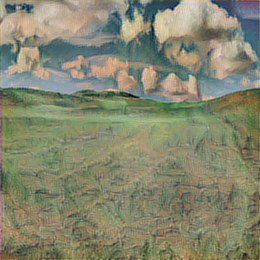

In [12]:
x = np.random.uniform(0, 255, (1, largura_imagem, altura_imagem, canais)) - 128. #iniciação aleatória
n = 10 # numero de iteracoes
for i in range(n):
    x, custo, info = fmin_l_bfgs_b(evaluator.custo, x.flatten(), fprime=evaluator.gradientes, maxfun=20)
    print("Iteracao %d completa com custo: %d" % (i + 1, custo))
    
x = x.reshape((largura_imagem, altura_imagem, canais))
x = x[:, :, ::-1] # BGR para RGB
# Retira a normalização pela média da ImageNet
x[:, :, 0] += media_rgb_imagenet[2]
x[:, :, 1] += media_rgb_imagenet[1]
x[:, :, 2] += media_rgb_imagenet[0]

x = np.clip(x, 0, 255).astype("uint8") # mantem os valores entre 0 e 255
output_image = Image.fromarray(x)
output_image.save('output.png')
output_image

## Visualizando imagens

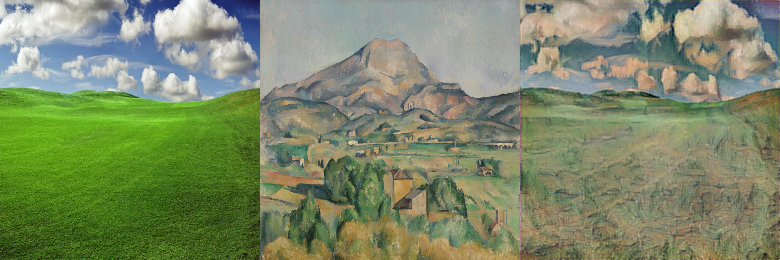

In [13]:
combinada = Image.new("RGB", (largura_imagem*3, altura_imagem))
x_offset = 0
for image in map(Image.open, ['entrada.png', 'estilo.png', 'output.png']):
    combinada.paste(image, (x_offset, 0))
    x_offset += largura_imagem
combinada.save('vis.png')
combinada